<!-- dom:TITLE: Uncertainty quantification and sensitivity analysis for arterial wall models -->
# Uncertainty quantification and sensitivity analysis for arterial wall models
**Vinzenz Gregor Eck**, Expert Analytics, Oslo  
 **Jacob Sturdy**  
 **Leif Rune Hellevik**  

Date: **Jul 13, 2018**  
Date: **Feb 01, 2026** 

In [1]:
# @title Install chaospy (Colab-friendly)

# Denne cellen sørger for at chaospy (og dermed numpoly) er tilgjengelig
# uten å tukle med numpy-installasjonen til Colab.

try:
    import chaospy as cp
    import numpoly
    import numpy as np
    print("chaospy er allerede installert.")
except ImportError:
    # Installer chaospy fra PyPI. Dette drar inn numpoly automatisk.
    %pip install chaospy==4.3.21 --no-cache-dir

    import chaospy as cp
    import numpoly
    import numpy as np

print("numpy  :", np.__version__)
print("numpoly:", numpoly.__version__)
print("chaospy:", cp.__version__)


chaospy er allerede installert.
numpy  : 2.2.6
numpoly: 1.3.6
chaospy: 4.3.20


In [2]:
# @title Layout fix, imports, and NumPy compatibility patch

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
HTML("""
<style>
div.cell.code_cell, div.output {
    max-width: 100% !important;
}
</style>
""")

from IPython.display import HTML

HTML("""
<style>
/* Make notebook content use full width */
.jp-NotebookPanel, .jp-Notebook, .jp-Notebook-container {
  width: 100% !important;
}

/* Prevent output area from forcing horizontal scrollbars */
.jp-OutputArea, .jp-OutputArea-output {
  overflow-x: visible !important;
}

/* If JupyterLab puts the output in a scroll box, disable it */
.output_scroll {
  overflow-x: visible !important;
  max-height: none !important;
}

/* Make figures responsive inside output area */
.jp-OutputArea-output figure, 
.jp-OutputArea-output img {
  max-width: 100% !important;
  height: auto !important;
}
</style>
""")


import numpy as np
import matplotlib.pyplot as plt
import chaospy as cp
import numpoly
import pandas as pd

%matplotlib inline
plt.rcdefaults()

# --- SAFE NumPy reshape patch (idempotent) ---
if not hasattr(np, "_original_reshape"):
    np._original_reshape = np.reshape

def reshape_compat(a, *args, **kwargs):
    newshape = kwargs.pop("newshape", None)
    if newshape is None:
        newshape = kwargs.pop("shape", None)

    if newshape is not None:
        return np._original_reshape(a, newshape, *args, **kwargs)
    return np._original_reshape(a, *args, **kwargs)

np.reshape = reshape_compat
print("✓ numpy.reshape safely patched (once)")





✓ numpy.reshape safely patched (once)


In [3]:
# @title Repo sync and environment setup (local + Colab safe)

import os, sys, subprocess
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
REMOTE = "https://github.com/lrhgit/uqsa2025.git"

if IN_COLAB:
    REPO_PATH = Path("/content/uqsa2025")
    if not REPO_PATH.exists():
        print("Cloning repository...")
        subprocess.run(["git", "clone", REMOTE, str(REPO_PATH)], check=True)
    else:
        print("Updating existing repository...")
        subprocess.run(["git", "-C", str(REPO_PATH), "pull"], check=True)
    os.chdir(REPO_PATH)
else:
    # running locally → infer repo root from cwd
    cwd = Path.cwd().resolve()
    REPO_PATH = next(
        (p for p in [cwd] + list(cwd.parents) if (p / "python_source").exists()),
        None
    )
    if REPO_PATH is None:
        raise RuntimeError("Could not locate repo root with python_source")

# add python_source to sys.path
PY_SRC = REPO_PATH / "python_source"
if str(PY_SRC) not in sys.path:
    sys.path.insert(0, str(PY_SRC))

print("CWD:", Path.cwd())
print("Repo root:", REPO_PATH)
print("python_source exists:", PY_SRC.exists())
print("python_source in sys.path:", str(PY_SRC) in sys.path)


CWD: /Users/leifh/git/uqsa2025
Repo root: /Users/leifh/git/uqsa2025
python_source exists: True
python_source in sys.path: True


In [4]:
from monte_carlo import generate_sample_matrices_mc
from monte_carlo import calculate_sensitivity_indices_mc
from plot_sobol import plot_sobol_mc_vs_pce
from pretty_printing import (
    pretty_table,
    section_title,
    sobol_summary_table,
    uncertainty_summary_table,
)



unit_mmhg_pa = 133.3
unit_pa_mmhg = 1./unit_mmhg_pa
unit_cm2_m2 = 1. / 100. / 100.
unit_m2_cm2 = 1. / unit_cm2_m2

# Introduction
<div id="sec:introduction"></div>
The arterial wall models we are investigating in this part, are used to describe the (visco-)elastic behaviour of arteries in one-dimensional
simulations of the cardiovascular system.

# Arterial Wall Models
<div id="sec:polynomialChaos"></div>

The elastic wall models are simplified algebraic functions $A(P)$ ([[eck2015stochastic;@boileau_benchmark_2015]](#eck2015stochastic;@boileau_benchmark_2015)),
which state the arterial lumen area $A$ as function of transmural pressure $P$.

For the calibration of the applied wall models, the wave speed in an arterial segment is required.
The wave speed is given from fluid dynamics equations for one-dimensional arteries ([[eck2015stochastic]](#eck2015stochastic)):


$$
c(P) = \sqrt{\frac{A(P)}{\rho\ C(P)}},
$$

with blood density $\rho= 1050\ [kg\ m^{-3}]$ and compliance $C(P) = dA / dP$.

## *Quadratic* model
The *Quadratic* area-pressure relationship ([[sherwin2003]](#sherwin2003)) is defined as:

$$
A(P) = \left((P-P_s) \frac{A_s}{\lambda} + \sqrt{A_s} \right)^2,
$$

where $\lambda$ is referred to as the stiffness coefficient and $A_s$
is the area at the reference pressure $P_s$.

The stiffness coefficient $\lambda$ is defined as:

$$
\lambda = \frac{2 \rho c_s^2 A_s}{\sqrt{A_s}}
$$

The model is implemented in the following function:

In [5]:
# begin quadratic area model
def quadratic_area_model(pressure_range, samples):
    """
    calculate the arterial vessel wall for a set pressure range
    from 75 to 140 mmHg for a given set of reference wave speeds
    area and pressure.

    :param
        pressure_range: np.array
            pressure range for which to calculate the arterial area

        samples: np.array with shape (4:n_samples)
            sample matrix where
            first indices correspond to
                a_s: reference area
                c_s: reference waves seed
                p_s: reference pressure
                rho: blood density
            and n_samples to the number of samples

    :return:
        arterial pressure : np.array
            of size n_samples
    """
    pressure_range = pressure_range.reshape(pressure_range.shape[0], 1)
    a_s, c_s, p_s, rho = samples
    beta = 2*rho*c_s**2/np.sqrt(a_s)*a_s
    #C_Laplace = (2. * ((P - Ps) * As / betaLaplace + np.sqrt(As))) * As / betaLaplace
    return ((pressure_range - p_s)*a_s/beta + np.sqrt(a_s))**2.

## *Logarithmic* model
The *Logarithmic* area-pressure relationship ([[Hayashi1980]](#Hayashi1980)) is defined as:

$$
A(P) = A_s \left( 1 + \frac{1}{\beta} \ln \left(\frac{P}{P_s}\right) \right)^2,
$$

where $\beta$ is called the stiffness coefficient and $A_s$ is the
area at the reference pressure $P_s$.

The stiffness coefficient $\beta$ is defined as:

$$
\beta = \frac{2\ \rho c_s^2}{P_s}
$$

The model is implemented in the following function:

In [6]:
# begin exponential area model
def logarithmic_area_model(pressure_range, samples):
    """
    calculate the arterial vessel wall for a set pressure range
    from 75 to 140 mmHg for a given set of reference wave speeds
    area and pressure.

    :param
        pressure_range: np.array
            pressure range for which to calculate the arterial area

        samples: np.array with shape (4:n_samples)
            sample matrix where
            first indices correspond to
                a_s: reference area
                c_s: reference waves seed
                p_s: reference pressure
                rho: blood density
            and n_samples to the number of samples

    :return:
        arterial pressure : np.array
            of size n_samples
    """
    pressure_range = pressure_range.reshape(pressure_range.shape[0], 1)
    a_s, c_s, p_s, rho = samples
    beta = 2.0*rho*c_s**2./p_s
    #C_hayashi = 2.0 * As / betaHayashi * (1.0 + np.log(P / Ps) / betaHayashi) / P
    return a_s*(1.0 + np.log(pressure_range / p_s)/beta) ** 2.0

## Comparison

For a comparison of the wall models, we set the reference values to:

$$
\begin{align*}
A_s &= 5.12  \;\mathrm{cm^2}      \\
c_s &= 6.256 \;\mathrm{m/s}       \\
P_s &= 100   \;\mathrm{mmHg}      \\
\rho &= 1045 \; \mathrm{kg/m^3}
\end{align*}
$$

The two wall models give almost the same result around the reference area and pressure, for which the model was calibrated.

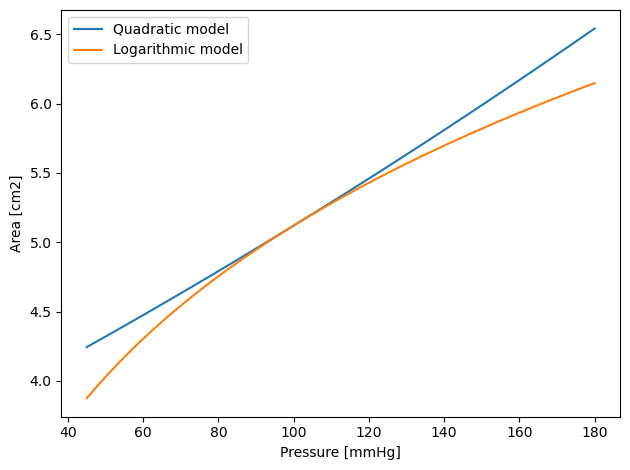

In [7]:
# start deterministic comparison
pressure_range = np.linspace(45, 180, 100) * unit_mmhg_pa
a_s = 5.12 * unit_cm2_m2
c_s = 6.25609258389
p_s = 100 * unit_mmhg_pa
rho = 1045.

plt.figure()
for model, name in [(quadratic_area_model, 'Quadratic model'), (logarithmic_area_model, 'Logarithmic model')]:
    y_area = model(pressure_range, (a_s, c_s, p_s, rho))
    plt.plot(pressure_range * unit_pa_mmhg, y_area * unit_m2_cm2, label=name)
    plt.xlabel('Pressure [mmHg]')
    plt.ylabel('Area [cm2]')
    plt.legend()
plt.tight_layout()

# Uncertainty Quantification and Sensitivity Analysis
<div id="sec:uqsa"></div>

## Definition of uncertain input parameters
For each model input, we define a uniform distributed random variable which varies with a deviation of $5\%$ around the deterministic value from above:

$$
\begin{align*}
A_s &= 5.12  \; \mathrm{cm^2}    \quad Z_0 = \mbox{U}(4.864, 5.376) \\
c_s &= 6.256 \; \mathrm{m/s}     \quad Z_1 = \mbox{U}(5.943, 6.569) \\
P_s &= 100   \; \mathrm{mmHg}    \quad Z_2 = \mbox{U}(95.0, 105.0) \\
\rho &= 1045 \; \mathrm{kg/m^3}  \quad Z_3 = \mbox{U}(992.75, 1097.25) 
\end{align*}
$$

In [8]:
# Create marginal and joint distributions
dev = 0.05
a_s = 5.12 * unit_cm2_m2
A_s = cp.Uniform(a_s * (1. - dev), a_s*(1. + dev))

c_s = 6.25609258389
C_s = cp.Uniform(c_s * (1. - dev), c_s*(1. + dev))

p_s = 100 * unit_mmhg_pa
P_s = cp.Uniform(p_s * (1. - dev), p_s*(1. + dev))

rho = 1045.
Rho = cp.Uniform(rho * (1. - dev), rho*(1. + dev))

jpdf = cp.J(A_s, C_s, P_s, Rho)

## Scatter plots and Samples

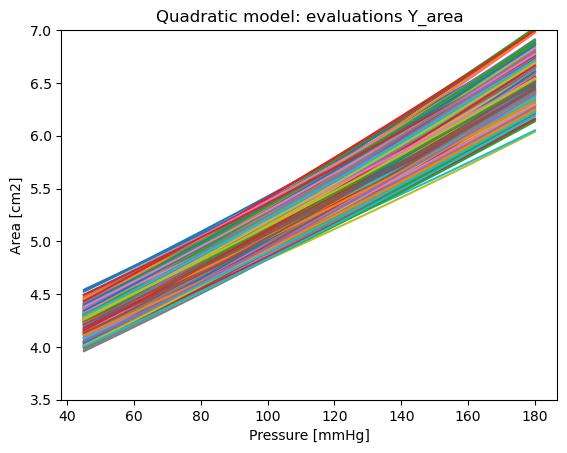

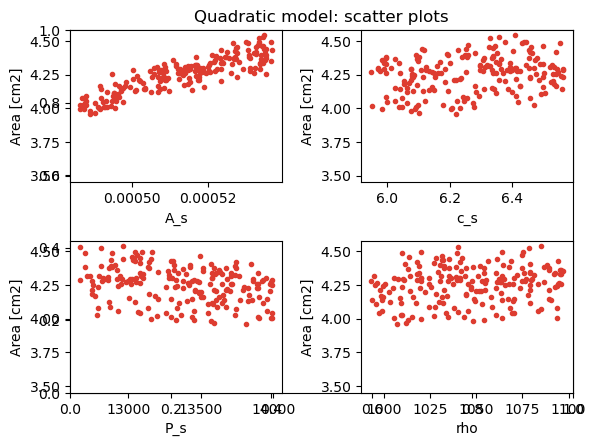

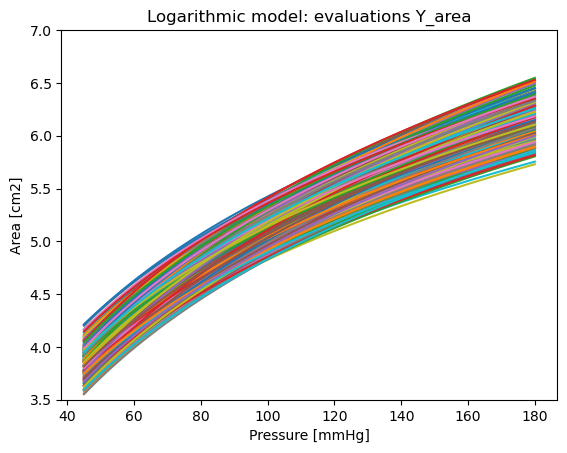

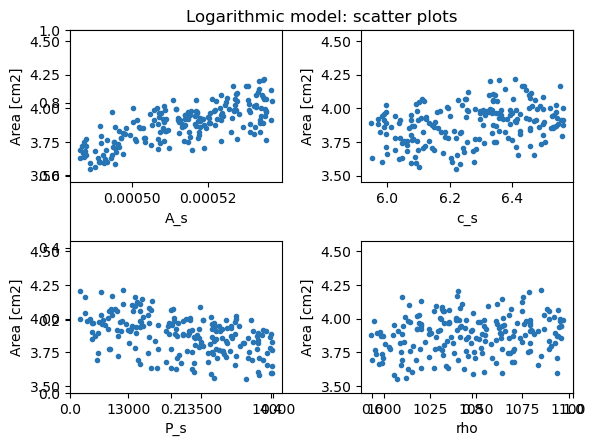

In [9]:
# scatter plots
pressure_range = np.linspace(45, 180, 100) * unit_mmhg_pa
Ns = 200
sample_scheme = 'R'
samples = jpdf.sample(Ns, sample_scheme)

# --- mapping between physical parameters and Zi ---
param_names = ["A_s", "c_s", "P_s", "rho"]
z_labels = [f"{param_names[k]}" for k in range(len(param_names))]

for model, name, color in [(quadratic_area_model, 'Quadratic model', '#dd3c30'), (logarithmic_area_model, 'Logarithmic model', '#2775b5')]:
    # evaluate the model for all samples
    Y_area = model(pressure_range, samples)

    plt.figure()
    plt.title('{}: evaluations Y_area'.format(name))
    plt.plot(pressure_range * unit_pa_mmhg, Y_area * unit_m2_cm2)
    plt.xlabel('Pressure [mmHg]')
    plt.ylabel('Area [cm2]')
    plt.ylim([3.5,7.])

    plt.figure()
    plt.title('{}: scatter plots'.format(name))
    for k in range(len(jpdf)):
        plt.subplot(len(jpdf)//2, len(jpdf)//2, k+1)
        plt.plot(samples[k], Y_area[0]*unit_m2_cm2, '.', color=color)
        plt.ylabel('Area [cm2]')
        plt.ylim([3.45, 4.58])
        #xlbl = 'Z' + str(k)
        plt.xlabel(z_labels[k])
    plt.tight_layout()

## Monte Carlo

We apply the Monte Carlo method for both models as discussed before:

In [10]:
# --- Common: containers for results (MC and PCE) ---

labels = ["Area", "wave speed", "pressure", "density"]
N = len(labels)
ind = np.arange(N)
width = 0.35

models = [
    ("Quadratic model", quadratic_area_model),
    ("Logarithmic model", logarithmic_area_model),
]

sobol_mc  = {}   # sobol_mc[name]  = dict(S=..., ST=..., E=..., Std=...)
sobol_pce = {}   # sobol_pce[name] = dict(S=..., ST=..., E=..., Std=...)


In [11]:
# --- Monte Carlo: compute + store only ---

pressure_range = np.linspace(45, 180, 100) * unit_mmhg_pa
Ns = 50000
sample_method = "R"
number_of_parameters = len(jpdf)

# Generate sample matrices
A, B, C = generate_sample_matrices_mc(Ns, number_of_parameters, jpdf, sample_method)

print("\nMC uncertainty measures (variance-weighted over pressure)\n")
print("  E(Y)  |  Std(Y) \n")

for name, model in models:

    # Evaluate model
    Y_A = model(pressure_range, A.T)  # (nP, Ns)
    Y_B = model(pressure_range, B.T)  # (nP, Ns)

    nP = len(pressure_range)
    Y_C = np.empty((nP, Ns, number_of_parameters))
    for i in range(number_of_parameters):
        Y_C[:, :, i] = model(pressure_range, C[i, :, :].T)

    # Statistics from A and B ensembles
    Y = np.hstack([Y_A, Y_B])               # (nP, 2Ns)
    expected_value = np.mean(Y, axis=1)     # (nP,)
    variance       = np.var(Y, axis=1)      # (nP,)
    std            = np.sqrt(variance)      # (nP,)

    # MC Sobol indices as function of pressure
    S_p  = np.zeros((number_of_parameters, nP))
    ST_p = np.zeros((number_of_parameters, nP))

    for j in range(nP):
        yA = Y_A[j, :]       # (Ns,)
        yB = Y_B[j, :]       # (Ns,)
        yC = Y_C[j, :, :]    # (Ns, P)
        Sj, STj = calculate_sensitivity_indices_mc(yA, yB, yC)
        S_p[:, j]  = Sj
        ST_p[:, j] = STj

    # Variance-weighted average over pressure range (your chosen aggregation)
    w = variance
    S_avg  = np.mean(S_p  * w, axis=1) / np.mean(w)
    ST_avg = np.mean(ST_p * w, axis=1) / np.mean(w)

    # Also store variance-weighted mean/std of Y across pressure
    E_avg   = np.mean(expected_value * w) / np.mean(w)
    Std_avg = np.mean(std * w) / np.mean(w)

    sobol_mc[name] = dict(
        S=S_avg, ST=ST_avg,
        E=E_avg * unit_m2_cm2,
        Std=Std_avg * unit_m2_cm2,
        S_p=S_p, ST_p=ST_p, variance=variance
    )

    print(f"{sobol_mc[name]['E']:.5f} | {sobol_mc[name]['Std']:.5f} : {name}")



MC uncertainty measures (variance-weighted over pressure)

  E(Y)  |  Std(Y) 

5.53786 | 0.17536 : Quadratic model
5.31480 | 0.16644 : Logarithmic model


In [12]:
# --- PCE: compute + store only ---

pressure_range = np.linspace(45, 180, 100) * unit_mmhg_pa
polynomial_order = 3

# Build basis and choose regression sample count
orth = cp.expansion.stieltjes(polynomial_order, jpdf)
Ns_pce = 2 * len(orth)

print("\nPCE uncertainty measures (variance-weighted over pressure)\n")
print(f"Ns = {Ns_pce}\n")
print("  E(Y)  |  Std(Y) \n")

samples = jpdf.sample(Ns_pce, "R")  # (dim, Ns)

for name, model in models:

    # Model evaluations for regression targets
    Y_area = model(pressure_range, samples)  # expect (nP, Ns)
    # Fit regression: (Ns, nP) target
    pce = cp.fit_regression(orth, samples, Y_area.T)

    expected_value = cp.E(pce, jpdf)               # (nP,)
    variance       = cp.Var(pce, jpdf)             # (nP,)
    standard_deviation = cp.Std(pce, jpdf)         # (nP,)

    # Sensitivities as function of pressure
    S  = cp.Sens_m(pce, jpdf)   # typically (dim, nP)
    ST = cp.Sens_t(pce, jpdf)   # typically (dim, nP)

    # Variance-weighted average over pressure range (same aggregation)
    w = variance
    S_avg  = np.mean(S  * w, axis=1) / np.mean(w)
    ST_avg = np.mean(ST * w, axis=1) / np.mean(w)

    # Variance-weighted mean/std of Y across pressure
    E_avg   = np.mean(expected_value * w) / np.mean(w)
    Std_avg = np.mean(standard_deviation * w) / np.mean(w)

    sobol_pce[name] = dict(
        S=S_avg, ST=ST_avg,
        E=E_avg * unit_m2_cm2,
        Std=Std_avg * unit_m2_cm2,
        S_p=S, ST_p=ST, variance=np.asarray(variance)
    )

    print(f"{sobol_pce[name]['E']:.5f} | {sobol_pce[name]['Std']:.5f} : {name}")



PCE uncertainty measures (variance-weighted over pressure)

Ns = 70

  E(Y)  |  Std(Y) 

5.54007 | 0.17533 : Quadratic model
5.31734 | 0.16638 : Logarithmic model


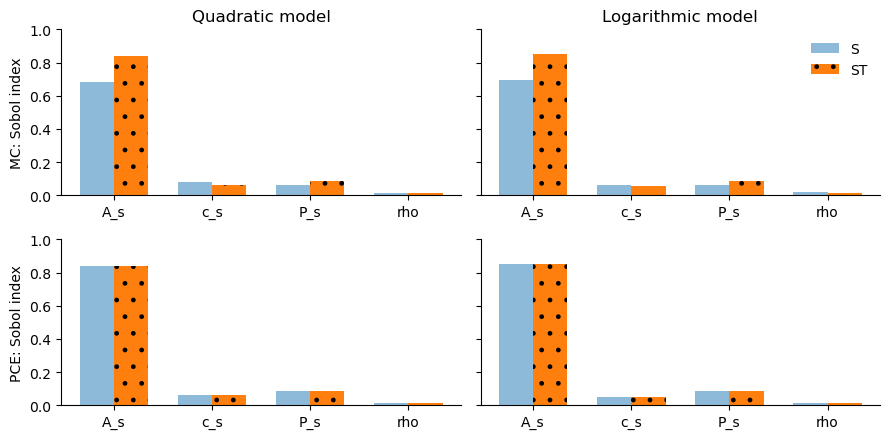

In [13]:
fig, axes = plot_sobol_mc_vs_pce(
    sobol_mc=sobol_mc,
    sobol_pce=sobol_pce,
    labels=z_labels,
    col_order=["Quadratic model", "Logarithmic model"],
    width=width,
)

plt.show()


In [14]:
for model_name in ["Quadratic model", "Logarithmic model"]:
    display(section_title(f"Sobol indices – {model_name}", level=4))

    df = sobol_summary_table(
        sobol_mc=sobol_mc,
        sobol_pce=sobol_pce,
        model_name=model_name,
        labels=z_labels,
    )

    pretty_table(df, decimals=3)


,S (MC),ST (MC),S (PCE),ST (PCE)
A_s,0.680,0.836,0.838,0.838
c_s,0.079,0.063,0.062,0.062
P_s,0.059,0.085,0.084,0.085
rho,0.012,0.016,0.015,0.016


,S (MC),ST (MC),S (PCE),ST (PCE)
A_s,0.692,0.850,0.850,0.851
c_s,0.062,0.053,0.052,0.052
P_s,0.062,0.085,0.084,0.084
rho,0.017,0.013,0.013,0.013


# References

 1. <div id="eck2015stochastic"></div> **V. G. Eck, J. Feinberg, H. P. Langtangen and L. R. Hellevik**. 
    Stochastic Sensitivity Analysis for Timing and Amplitude of Pressure waves in the Arterial System,
    *International Journal for Numerical Methods in Biomedical Engineering*,
    31(4),
    2015.

 2. <div id="boileau_benchmark_2015"></div> **E. Boileau, P. Nithiarasu, P. J. Blanco, L. O. Mueller, F. E. Fossan, L. R. Hellevik, W. P. Donders, W. Huberts, M. Willemet and J. Alastruey**. 
    A benchmark study of numerical schemes for one-dimensional arterial blood flow modelling,
    *International Journal for Numerical Methods in Biomedical Engineering*,
    31(10),
    pp. n/a-n/a,
    2015.

 3. <div id="sherwin2003"></div> **S. Sherwin, V. Franke, J. Peir\'o and K. Parker**. 
    One-Dimensional Modelling of Vascular Network in Space-Time Variables,
    *Journal of Engineering Mathematics*,
    47(3-4),
    pp. 217-233,
    2003.

 4. <div id="Hayashi1980"></div> **K. Hayashi, H. Handa, S. Nagasawa, A. Okumura and K. Moritake**. 
    Stiffness and Elastic Behavior of Human Intracranial and Extracranial arteries,
    *Journal of Biomechanics*,
    13(2),
    pp. 175-184,
    1980.